<a href="https://colab.research.google.com/github/yyyewon/walkvsrun/blob/main/walk_mlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch 1/20, Loss: 0.2785, Accuracy: 0.9415
Epoch 2/20, Loss: 0.1096, Accuracy: 0.9630
Epoch 3/20, Loss: 0.0792, Accuracy: 0.9655
Epoch 4/20, Loss: 0.0593, Accuracy: 0.9658
Epoch 5/20, Loss: 0.0437, Accuracy: 0.9682
Epoch 6/20, Loss: 0.0330, Accuracy: 0.9621
Epoch 7/20, Loss: 0.0282, Accuracy: 0.9638
Epoch 8/20, Loss: 0.0227, Accuracy: 0.9677
Epoch 9/20, Loss: 0.0206, Accuracy: 0.9639
Epoch 10/20, Loss: 0.0164, Accuracy: 0.9631
Epoch 11/20, Loss: 0.0151, Accuracy: 0.9660
Epoch 12/20, Loss: 0.0127, Accuracy: 0.9654
Epoch 13/20, Loss: 0.0119, Accuracy: 0.9640
Epoch 14/20, Loss: 0.0124, Accuracy: 0.9664
Epoch 15/20, Loss: 0.0099, Accuracy: 0.9642
Epoch 16/20, Loss: 0.0111, Accuracy: 0.9641
Epoch 17/20, Loss: 0.0086, Accuracy: 0.9666
Epoch 18/20, Loss: 0.0108, Accuracy: 0.9650
Epoch 19/20, Loss: 0.0088, Accuracy: 0.9671
Epoch 20/20, Loss: 0.0076, Accuracy: 0.9638


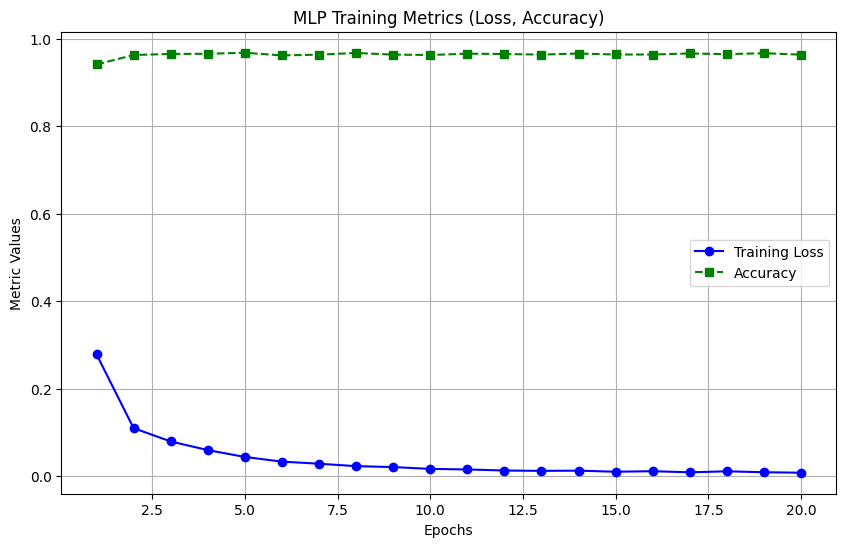

In [1]:
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# === 데이터셋 준비 === #
class TimeSeriesDataset(Dataset):
    def __init__(self, data, features, target, seq_length=10):
        self.features = data[features].values
        self.targets = data[target].values
        self.seq_length = seq_length

    def __len__(self):
        return len(self.features) - self.seq_length + 1

    def __getitem__(self, idx):
        X = self.features[idx:idx + self.seq_length].flatten()  # Flatten하여 1D 벡터로 변환
        y = self.targets[idx + self.seq_length - 1]
        return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.long)

# === MLP 기반 분류기 === #
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes, hidden_dim=128):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.fc3 = nn.Linear(hidden_dim // 2, num_classes)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

# === 데이터 읽기 === #
file_path = "walkvsrun_sorted.csv"
data = pd.read_csv(file_path)

# === 데이터 전처리 === #
data['full_datetime'] = pd.to_datetime(data['full_datetime'], format='%Y-%m-%d %H:%M:%S.%f', errors='coerce')

features = ['acceleration_x', 'acceleration_y', 'acceleration_z', 'gyro_x', 'gyro_y', 'gyro_z']
target = 'activity'

train_data, test_data = train_test_split(data, test_size=0.2, random_state=42, stratify=data[target])

# Dataset과 DataLoader 생성
seq_length = 50  # 윈도우 크기 설정
input_dim = len(features) * seq_length  # Flatten을 고려한 입력 크기
num_classes = data[target].nunique()

train_dataset = TimeSeriesDataset(train_data, features, target, seq_length)
test_dataset = TimeSeriesDataset(test_data, features, target, seq_length)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# === 모델 학습 === #
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MLPClassifier(input_dim=input_dim, num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 학습 루프
epochs = 20
loss_values, accuracy_values = [], []

for epoch in range(epochs):
    model.train()
    train_loss = 0

    for X, y in train_loader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        output = model(X)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    loss_values.append(train_loss / len(train_loader))

    # 모델 평가
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for X, y in test_loader:
            X, y = X.to(device), y.to(device)
            output = model(X)
            _, predicted = torch.max(output, 1)
            y_true.extend(y.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    accuracy = accuracy_score(y_true, y_pred)
    accuracy_values.append(accuracy)

    print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss_values[-1]:.4f}, Accuracy: {accuracy:.4f}")

# === 시각화 === #
plt.figure(figsize=(10, 6))

# Loss 그래프
plt.plot(range(1, epochs + 1), loss_values, marker='o', linestyle='-', label='Training Loss', color='b')

# Accuracy 그래프
plt.plot(range(1, epochs + 1), accuracy_values, marker='s', linestyle='--', label='Accuracy', color='g')

# 그래프 설정
plt.xlabel('Epochs')
plt.ylabel('Metric Values')
plt.title('MLP Training Metrics (Loss, Accuracy)')
plt.legend()
plt.grid()

# 그래프 출력
plt.show()
